In [19]:
import numpy as np
import torch
from torch import nn, Tensor
from torch import optim
import matplotlib.pyplot as plt
from dataset_pre import minst
from tqdm import tqdm

In [2]:
np.random.seed(33)   # random seed，to reproduce results.

# 参数

In [3]:
ENCODING_DIM_INPUT = 784
ENCODING_DIM_OUTPUT = 2
EPOCHS = 20
BATCH_SIZE = 64
SAVE_PATH = "autoencoder.pth"

# model

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(ENCODING_DIM_INPUT, ENCODING_DIM_OUTPUT),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_DIM_OUTPUT, ENCODING_DIM_INPUT),
            nn.ReLU(),
        )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        x = self.encoder(x) # [B, 784] -> [B, 2]
        y = self.decoder(x) # [B, 2] -> [B, 784]
        return x, y

# train

In [ ]:
torch.cuda.is_available()

In [5]:

def train():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = AutoEncoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    _, _, train_dataloader, val_dataloader = minst(batch_size=64)

    # 初始loss设置为最大值
    MIN_LOSS = np.Inf

    for epoch in range(EPOCHS):
        # train
        pbar = tqdm(total=len(train_dataloader), desc=f"epoch {epoch+1}/{EPOCHS} train")
        model.train()
        for images, label in train_dataloader:
            images = images.flatten(1)  # [B, C, H, W] -> [B, C*H*W]
            images = images.to(device)

            # forward
            _, images_encoder = model(images)

            loss = loss_fn(images, images_encoder)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix(**{"loss": loss.item()})
        pbar.close()

        # val
        pbar = tqdm(total=len(val_dataloader), desc=f"epoch {epoch+1}/{EPOCHS} val")
        model.eval()
        losssum = 0
        for images, label in val_dataloader:
            images = images.flatten(1)  # [B, C, H, W] -> [B, C*H*W]
            images = images.to(device)

            # forward
            with torch.inference_mode():
                _, images_encoder = model(images)

            loss = loss_fn(images, images_encoder)
            losssum += loss.item()

            pbar.update(1)
            pbar.set_postfix(**{"loss": loss.item()})
        var_loss_avg = losssum / len(val_dataloader)
        pbar.set_postfix(**{"avg_loss": var_loss_avg})
        pbar.close()

        # 保存权重
        if MIN_LOSS > var_loss_avg:
            MIN_LOSS = var_loss_avg
            torch.save(model.state_dict(), SAVE_PATH)

In [6]:
train()

train images: 60000, val images: 157


epoch 20/20 val: 100%|██████████| 157/157 [00:03<00:00, 47.53it/s, val_loss=0.0849] 


# 显示

In [26]:
def plot_representation(encode_images, y_test):
    """
    plot the hidden result.
    :param encode_images: the images after encoding
    :param y_test: the label.
    :return:
    """
    # test and plot
    plt.scatter(encode_images[:, 0], encode_images[:, 1], c=y_test, s=3)
    plt.colorbar()
    plt.show()

In [21]:
def show_images(decode_images, x_test):
    """
    plot the images.
    :param decode_images: the images after decoding
    :param x_test: testing data
    :return:
    """
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        ax.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        ax.imshow(decode_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [22]:
_, _, _, val_dataloader = minst(batch_size=10)
test_images, test_labels = next(iter(val_dataloader))

train images: 60000, val images: 1000


In [10]:
model = AutoEncoder()
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [17]:
model.eval()
with torch.inference_mode():
    test_images = test_images.flatten(1)
    encode_images, decode_images = model(test_images)

tensor([[0.9872, 0.0000],
        [0.9442, 0.0000],
        [0.1066, 0.0000],
        [1.9107, 0.0000],
        [1.3663, 0.0000],
        [0.0206, 0.0000],
        [1.0060, 0.0000],
        [0.8528, 0.0000],
        [1.2350, 0.0000],
        [1.2814, 0.0000]])


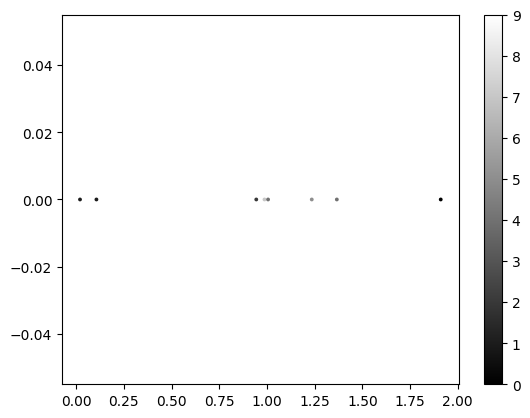

In [31]:
plot_representation(encode_images, test_labels)

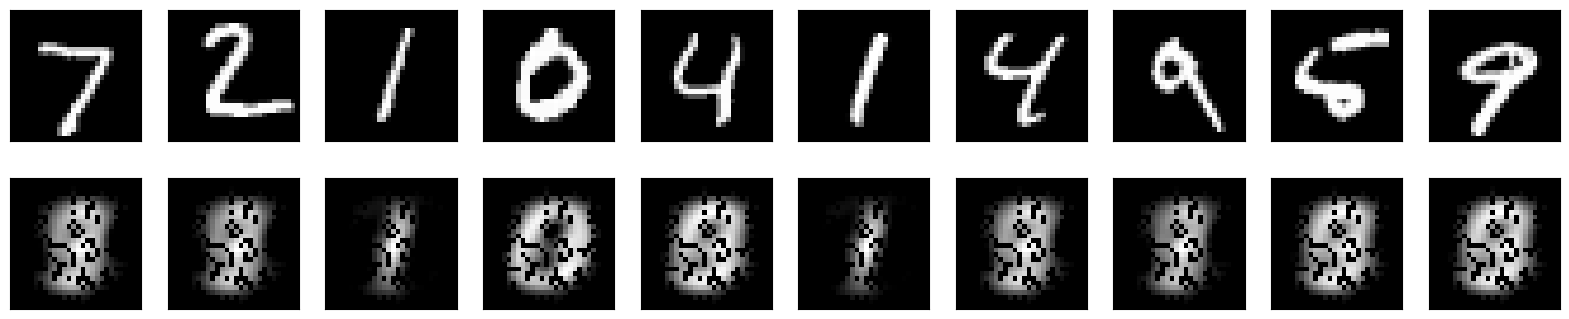

In [32]:
show_images(decode_images, test_images)